# Data Check

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling as pdp
import gc, os, csv
from plotnine import *
plt.rcParams["font.family"] = "IPAGothic"

IPAGothicは[こちら](https://ipafont.ipa.go.jp/old/fontinstall.html)からインストール

In [2]:
from IPython.display import display

def display_all(df):
    with pd.option_context("display.max_rows", 1000):
        with pd.option_context("display.max_columns", 1000):
            display(df)

In [3]:
!tree ../data

/bin/sh: tree: command not found


## 確認次項

- 以下のファイルについて、圧縮前のcsvデータをいただけますと幸いです。
    - dbhaa0001_process_199701_200212.csv
    - dbhaa0001_process_200901_201412.csv
    - tbhaa0006_fcok_20060401_20120330.csv
    - tbhaa0006_fcok_20120401_20180330.csv
- V_PROD_MODEL_CDとV_SALES_MODEL_CDの読み替え表
- システム変更の有無

## データ確認の流れ

1. フォーマットの確認(形式、サイズ、項目の意味、読み込めるか、等)
2. 各項目の基礎統計量とヒストグラム(算出できる項目について)を確認
3. 時系列データの場合は、時系列プロットを確認
4. 上記で異常値が見つかった場合、異常値を除去。不要な項目についても除去。
5. 各項目間の関連性を相関係数やMIC等で確認
6. グループを切って(層別して)、合計数や割合を確認
7. 上記で異常値が見つかった場合、異常値を除去。

分析者によって異なるが、眞田の場合は上記のようなプロセスに緩やかに従う。
今回は3までの進捗を報告。

ファイルのサイズが大きい場合、ひとまずメモリに乗る一部分を分析し、その後、DBやSpark、分割処理などを用いてスケーラビリティをもたせる方法がスムーズであり、今回もその方法に沿って行う。  
なお、グラフ分析を除いて、モデリングは一部のデータを用いた分析で十分なことが多い。  
今回の分析はメモリに乗る一部分について、pythonで分析を行った。  
次週、スケーラビリティをもたせたデータ確認についても報告予定。

## フォーマットの確認

In [7]:
!ls -lh ../data/raw/dbhaa0001_tbhaa0006/

total 25098752
-rw-r--r--  1 localadmin  staff   772M May  8 14:55 dbhaa0001_process_199701_200212.csv
-rwxr-xr-x@ 1 localadmin  staff   2.3G May  8 15:16 dbhaa0001_process_200301_200812.csv
-rw-r--r--  1 localadmin  staff   1.0G May  8 15:39 dbhaa0001_process_200901_201412.csv
-rwxr-xr-x@ 1 localadmin  staff   1.2G May  8 15:49 dbhaa0001_process_201501_201904.csv
-rwxr-xr-x@ 1 localadmin  staff   785M May  8 18:10 tbhaa0006_fcok_19940401_20000330.csv
-rwxr-xr-x@ 1 localadmin  staff   2.0G May  8 18:01 tbhaa0006_fcok_20000401_20060330.csv
-rw-r--r--  1 localadmin  staff   1.9G May  8 17:18 tbhaa0006_fcok_20060401_20120330.csv
-rw-r--r--  1 localadmin  staff   1.6G May  8 16:59 tbhaa0006_fcok_20120401_20180330.csv
-rwxr-xr-x@ 1 localadmin  staff   297M May  8 16:34 tbhaa0006_fcok_20180401_20190330.csv


- 各ファイルはcsv形式、サイズは最大2.3GB。1ファイルであればメモリ上にのるが、全体を処理する場合はファイル毎に処理する or DB上で処理する or サンプリングが必要
- 各項目の意味については受領したファイル(ワランティ・生産実績フォーマット.xlsx)を参照

In [8]:
!head ../data/raw/dbhaa0001_tbhaa0006/dbhaa0001_process_199701_200212.csv

In [9]:
!head ../data/raw/dbhaa0001_tbhaa0006/tbhaa0006_fcok_19940401_20000330.csv

カンマ区切り、ダブルクオーテーションで囲むが、タイムスタンプのみ囲みがない。

**読み込めるかチェック**

In [13]:
error_row = [] # エラーのある行を記録するリスト

PATH_RAW_DATA = "../data/raw/dbhaa0001_tbhaa0006/"
PATH_PROCESSED_DATA = "../data/interim/dbhaa0001_tbhaa0006/"
if not os.path.exists(PATH_PROCESSED_DATA):
    os.makedirs(PATH_PROCESSED_DATA)

for filename in [file for file in os.listdir(PATH_RAW_DATA) if "csv" in file]:
    print(f"proccesing {filename}...", end="")
    with open(f"{PATH_RAW_DATA}{filename}") as f:
        with open(f"{PATH_PROCESSED_DATA}processed_{filename}", "w") as w:
            reader = csv.reader(f)
            header = next(reader)
            writer = csv.writer(w)
            writer.writerow(header)
            i = 1 # include header
            while True:
                try:
                    val = next(reader)
                    writer.writerow(val)
                except StopIteration:
                    break
                except:
                    error_row.append((filename, i))
                i += 1
    print("Done.")

proccesing tbhaa0006_fcok_19940401_20000330.csv...Done.
proccesing dbhaa0001_process_201501_201904.csv...Done.
proccesing dbhaa0001_process_200901_201412.csv...Done.
proccesing dbhaa0001_process_200301_200812.csv...Done.
proccesing tbhaa0006_fcok_20180401_20190330.csv...Done.
proccesing dbhaa0001_process_199701_200212.csv...Done.
proccesing tbhaa0006_fcok_20060401_20120330.csv...Done.
proccesing tbhaa0006_fcok_20000401_20060330.csv...Done.
proccesing tbhaa0006_fcok_20120401_20180330.csv...Done.


In [14]:
error_row

[('dbhaa0001_process_200301_200812.csv', 4005091)]

In [15]:
# check csv table is readable
for filename in [file for file in os.listdir(PATH_PROCESSED_DATA) if "csv" in file]:
    print(f"proaccesing {filename}...", end="")
    try:
        df_tmp = pd.read_csv(f"{PATH_PROCESSED_DATA}{filename}")
        print("OK")
    except:
        print("NG")

proaccesing processed_tbhaa0006_fcok_19940401_20000330.csv...

/Users/localadmin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (5,6,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


OK
proaccesing processed_dbhaa0001_process_200301_200812.csv...

/Users/localadmin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (2,5,6,7,9,11,12,16,17,18,20,22,28,29,31,33,41,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


OK
proaccesing processed_dbhaa0001_process_201501_201904.csv...

/Users/localadmin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (7,11,12,13,14,18,20,27,28,29,30,33,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


OK
proaccesing processed_dbhaa0001_process_200901_201412.csv...NG
proaccesing processed_tbhaa0006_fcok_20180401_20190330.csv...

/Users/localadmin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (5,11,17,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


OK
proaccesing processed_dbhaa0001_process_199701_200212.csv...NG
proaccesing processed_tbhaa0006_fcok_20060401_20120330.csv...NG
proaccesing processed_tbhaa0006_fcok_20000401_20060330.csv...

/Users/localadmin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (5,6,17,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


OK
proaccesing processed_tbhaa0006_fcok_20120401_20180330.csv...NG


以下のファイルが読み込めなかった。-> 圧縮で問題が発生している可能性があるため、圧縮前のデータをいただきたい。
- dbhaa0001_process_199701_200212.csv
- dbhaa0001_process_200901_201412.csv
- tbhaa0006_fcok_20060401_20120330.csv
- tbhaa0006_fcok_20120401_20180330.csv

## 基礎統計

### 生産データ

In [16]:
!ls -lh {PATH_PROCESSED_DATA}

total 19357592
-rw-r--r--  1 localadmin  staff     0B Jun 11 06:01 processed_.DS_Store
-rw-r--r--  1 localadmin  staff   603M Jun 11 06:10 processed_dbhaa0001_process_199701_200212.csv
-rw-r--r--  1 localadmin  staff   1.8G Jun 11 06:09 processed_dbhaa0001_process_200301_200812.csv
-rw-r--r--  1 localadmin  staff   828M Jun 11 06:08 processed_dbhaa0001_process_200901_201412.csv
-rw-r--r--  1 localadmin  staff   1.0G Jun 11 06:07 processed_dbhaa0001_process_201501_201904.csv
-rw-r--r--  1 localadmin  staff   597M Jun 11 06:07 processed_tbhaa0006_fcok_19940401_20000330.csv
-rw-r--r--  1 localadmin  staff   1.5G Jun 11 06:12 processed_tbhaa0006_fcok_20000401_20060330.csv
-rw-r--r--  1 localadmin  staff   1.4G Jun 11 06:11 processed_tbhaa0006_fcok_20060401_20120330.csv
-rw-r--r--  1 localadmin  staff   1.2G Jun 11 06:13 processed_tbhaa0006_fcok_20120401_20180330.csv
-rw-r--r--  1 localadmin  staff   225M Jun 11 06:10 processed_tbhaa0006_fcok_20180401_20190330.csv


In [29]:
df_froc = pd.read_csv(f"{PATH_PROCESSED_DATA}processed_tbhaa0006_fcok_20180401_20190330.csv")

/Users/localadmin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (5,11,17,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [30]:
df_froc.shape

(1452670, 27)

In [31]:
display_all(df_froc.head())

,V_BASE_CD,V_PROD_DIV,V_VIN,V_ENGINE_NO,V_MOTOR_NO,V_MISSON_NO,V_KEY_NO,V_FCOK,V_FCOK_TIME,V_ABOK,V_ABOK_TIME,V_PROD_MODEL_CD,V_SALES_MODEL_CD,V_SALES_MODEL_NM,V_SPEC,V_COLOR,V_PLANT_CD,V_DIST_CD,V_BRANCH_CD,V_SHIPPING_DATE,V_SHIPPING_FCOK,V_SHIPPING_ABOK,V_INVOICE_NO,V_SALES_NO,V_CASE_NO,V_SRC_DIV,V_CRT_TIME_STAMP
0,100100,B,MK53S-861193,R06A-B670795,NaN,NaN,L0590,20190315,125424.0,20190315.0,112157.0,NaN,MK53S-ZTZP-JK,NaN,000,ZVR,NaN,403110,403080.0,20190313.0,NaN,NaN,NaN,NaN,NaN,1,19-04-19 15:32:01.583547000
1,100100,B,MK53S-861195,R06A-B671063,NaN,NaN,L4800,20190315,172154.0,20190315.0,162715.0,NaN,MK53S-ZTZB-J,NaN,000,DYA,NaN,403110,403080.0,20190313.0,NaN,NaN,NaN,NaN,NaN,1,19-04-19 15:32:01.587623000
2,100100,B,MK53S-861196,R06A-B670870,NaN,NaN,L0124,20190315,142233.0,20190315.0,132702.0,NaN,MK53S-ZTXB-JK,NaN,000,ZVR,NaN,502240,506070.0,20190313.0,NaN,NaN,NaN,NaN,NaN,1,19-04-19 15:32:01.599814000
3,100100,B,MK53S-861197,R06A-B670799,NaN,NaN,L0635,20190315,125636.0,20190315.0,112613.0,NaN,MK53S-ZTZP-JK,NaN,000,ZVC,NaN,308010,308020.0,20190313.0,NaN,NaN,NaN,NaN,NaN,1,19-04-19 15:32:01.603856000
4,100100,B,MK53S-861198,R06A-B670875,NaN,NaN,L0134,20190315,143021.0,20190315.0,134140.0,NaN,MK53S-ZTZB-JK,NaN,000,ZVR,NaN,500020,500060.0,20190313.0,NaN,NaN,NaN,NaN,NaN,1,19-04-19 15:32:01.606902000


In [32]:
display_all(df_froc.describe(include="all"))

,V_BASE_CD,V_PROD_DIV,V_VIN,V_ENGINE_NO,V_MOTOR_NO,V_MISSON_NO,V_KEY_NO,V_FCOK,V_FCOK_TIME,V_ABOK,V_ABOK_TIME,V_PROD_MODEL_CD,V_SALES_MODEL_CD,V_SALES_MODEL_NM,V_SPEC,V_COLOR,V_PLANT_CD,V_DIST_CD,V_BRANCH_CD,V_SHIPPING_DATE,V_SHIPPING_FCOK,V_SHIPPING_ABOK,V_INVOICE_NO,V_SALES_NO,V_CASE_NO,V_SRC_DIV,V_CRT_TIME_STAMP
count,1.452670e+06,1452670,1452670,1452670,0.0,633059,1451650,1.452670e+06,819611.000000,1.138861e+06,819611.000000,633059,1452466,0.0,819611,819611,0.0,1431775.0,798716.000000,1.409010e+06,0.0,0.0,633059,633059,633059,1452670.0,1452670
unique,NaN,3,1452670,1401261,NaN,160334,8917,NaN,NaN,NaN,NaN,833,1606,NaN,11,137,NaN,1591.0,NaN,NaN,NaN,NaN,11928,5536,114740,NaN,1452670
top,NaN,B,MK53S-166309,190227,NaN,,,NaN,NaN,NaN,NaN,XE391NE,A2L412F,NaN,000,26U,NaN,361000.0,NaN,NaN,NaN,NaN,,AJD-8411,000001,NaN,19-04-01 15:07:14.339751000
freq,NaN,1218457,1,292,NaN,457479,234213,NaN,NaN,NaN,NaN,19124,60237,NaN,701825,145351,NaN,43436.0,NaN,NaN,NaN,NaN,10459,3420,2641,NaN,1
mean,1.150977e+05,NaN,NaN,NaN,NaN,NaN,NaN,2.018327e+07,163815.656014,1.989131e+07,161327.552892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,438945.354181,2.018365e+07,NaN,NaN,NaN,NaN,NaN,1.0,NaN
std,4.212595e+04,NaN,NaN,NaN,NaN,NaN,NaN,4.130412e+03,58829.905697,2.408905e+06,59504.994369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,159628.573007,4.298607e+03,NaN,NaN,NaN,NaN,NaN,0.0,NaN
min,1.001000e+05,NaN,NaN,NaN,NaN,NaN,NaN,2.018040e+07,0.000000,0.000000e+00,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61310.000000,2.018040e+07,NaN,NaN,NaN,NaN,NaN,1.0,NaN
25%,1.001000e+05,NaN,NaN,NaN,NaN,NaN,NaN,2.018070e+07,112934.000000,2.018070e+07,105350.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,315410.000000,2.018072e+07,NaN,NaN,NaN,NaN,NaN,1.0,NaN
50%,1.001000e+05,NaN,NaN,NaN,NaN,NaN,NaN,2.018101e+07,162834.000000,2.018100e+07,161701.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,407750.000000,2.018102e+07,NaN,NaN,NaN,NaN,NaN,1.0,NaN
75%,1.110100e+05,NaN,NaN,NaN,NaN,NaN,NaN,2.019011e+07,214957.000000,2.018123e+07,213926.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,519060.000000,2.019012e+07,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [33]:
display_all((df_froc.isna().sum()/df_froc.shape[0]).sort_values(ascending=False).to_frame().T)

,V_SALES_MODEL_NM,V_SHIPPING_ABOK,V_PLANT_CD,V_SHIPPING_FCOK,V_MOTOR_NO,V_INVOICE_NO,V_SALES_NO,V_MISSON_NO,V_CASE_NO,V_PROD_MODEL_CD,V_BRANCH_CD,V_FCOK_TIME,V_ABOK_TIME,V_COLOR,V_SPEC,V_ABOK,V_SHIPPING_DATE,V_DIST_CD,V_KEY_NO,V_SALES_MODEL_CD,V_PROD_DIV,V_ENGINE_NO,V_VIN,V_CRT_TIME_STAMP,V_FCOK,V_SRC_DIV,V_BASE_CD
0,1.0,1.0,1.0,1.0,1.0,0.56421,0.56421,0.56421,0.56421,0.56421,0.450174,0.43579,0.43579,0.43579,0.43579,0.216022,0.030055,0.014384,0.000702,0.00014,0.0,0.0,0.0,0.0,0.0,0.0,0.0


半分程度欠損がある項目が見受けられる。海外の製品だと思われる。

In [25]:
import pandas_profiling as pdp

In [34]:
pd_report_df_froc = pdp.ProfileReport(df_froc)
PATH_REPORTS = "../reports/"
pd_report_df_froc.to_file(f"{PATH_REPORTS}pd_report_processed_tbhaa0006_fcok_20180401_20190330.csv.html")

In [35]:
pd_report_df_froc

Number of variables,27
Number of observations,1452670
Total Missing (%),38.1%
Total size in memory,299.2 MiB
Average record size in memory,216.0 B
Numeric,7
Categorical,11
Boolean,0
Date,0
Text (Unique),2
Rejected,6


- モデル名/モデルタイプ
    - V_PROD_MODEL_CDは同様の項目がワランティデータにもあるが、生産データでは欠損が多い(半分程度)。V_SALES_MODEL_CDは欠損がほぼないが、ワランティデータには項目なし。
    - 読み替え表があれば、V_SALES_MODEL_CDを使う方が望ましい。なければ、モデル名を用いた分析時は、国内データのみで一旦分析を行う。
- 地域
    - V_DIST_CDが良さそう。
    - V_BRANCH_CDは半分程度の欠損。国内にのみあるものと思われる。

- (スズキ様コメント)V_PROD_MODELは基本となるデータなので、欠損しているのは違和感。

In [36]:
del df_froc
gc.collect()

21684

### ワランティデータ

In [37]:
df_proc = pd.read_csv(f"{PATH_PROCESSED_DATA}processed_dbhaa0001_process_201501_201904.csv")

/Users/localadmin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (7,11,12,13,14,18,20,27,28,29,30,33,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [38]:
df_proc.shape

(4082108, 48)

In [39]:
display_all(df_proc.head())

,W_KEY,W_BASE_CD,W_PROD_BASE_CD,W_FIELD_CLAIM_DIV,W_PROD_DIV,W_DMEX_DIV,W_PROCESS_MONTH,W_DIST_CD,W_DIST_COUNTRY_CD,W_DIST_ISSUE_NO,W_SHOP_DIV,W_SHOP_CD,W_DIV1,W_DIV2,W_DIV3,W_FIXED_DIV,W_MINUS_DIV,W_SRC_DIV,W_SRC_KEY,W_VIN,W_FCOK,W_PROD_MODEL_CD,W_SALES_DATE,W_FAILURE_DATE,W_MILEAGE_DIV,W_MILEAGE,W_CAUSAL_PART_NO,W_TROUBLE_CC,W_TROUBLE_CP,W_TROUBLE_DF,W_TROUBLE_MP,W_DTC_1,W_DTC_2,W_OPERATION_CD,W_PARTS_AMT,W_LABOR_HOUR,W_LABOR_AMT,W_SUBLET_HOUR,W_SUBLET_AMT,W_SHIPPING_AMT,W_TOTAL_AMT,W_CFC_COMPANY_CD,W_CFC_RATE,W_CFC_AMT,W_FC_TO_FAILURE,W_SALES_TO_FAILURE,W_SB_NO,W_CRT_TIME_STAMP
0,WRJPJP201504B001202,100100,100100.0,1,B,0,201504,40223,JP,15C0100551,1.0,15,1,0,NaN,1,1,1,201504006777793,MH34S-702672,20120901,YV0E1B9J,20120928,20150323,K,16283,72350-72M02,99,76,24,9,NaN,NaN,NaN,910,0.2,1240,0.0,0,0,2150,3116,30,514,30,30,NaN,17-06-19 18:05:50.068344000
1,WRJPJP201504B001203,100100,100100.0,1,B,0,201504,40223,JP,15C0105891,1.0,15,1,0,NaN,1,1,1,201504006776105,MH34S-718306,20130101,YV0E1B9J,20130214,20150324,K,10433,72350-72M02,99,65,24,1,NaN,NaN,NaN,910,0.2,1240,0.0,0,0,2150,3116,30,514,26,26,NaN,17-06-19 18:05:50.071115000
2,WRJPJP201504B001204,100100,100100.0,1,B,0,201504,50224,JP,15D0054801,1.0,22,4,0,NaN,1,1,1,201504006791151,MH23S-837237,20100101,YG0B1B9D,20100129,20150413,K,43200,17931-58J01,99,85,29,4,NaN,NaN,NaN,878,0.2,1280,0.0,0,0,2158,3978,0,0,63,63,NaN,17-06-19 18:05:50.073222000
3,WRJPJP201504B001205,100100,100100.0,1,B,0,201504,50224,JP,15C0085531,1.0,78,1,0,NaN,1,1,1,201504006770379,MH23S-668540,20120401,YG0A2B9D,20120420,20150327,K,21877,17931-58J01,32,85,23,8,NaN,NaN,NaN,878,0.2,1280,0.0,0,0,2158,3978,50,783,35,36,NaN,17-06-19 18:05:50.075672000
4,WRJPJP201504B001206,100100,100100.0,1,B,0,201504,50224,JP,15C0057741,1.0,6,4,0,NaN,1,1,1,201504006772241,MK21S-197951,20100401,YT212B9F,20100409,20150313,K,32461,17931-58J01,99,85,29,8,NaN,NaN,NaN,878,0.2,1280,0.0,0,0,2158,3978,0,0,59,60,NaN,17-06-19 18:05:50.077429000


In [73]:
pr_df_proc = pdp.ProfileReport(df_proc)
pr_df_proc.to_file(f"{PATH_REPORTS}pd_report_processed_dbhaa0001_process_201501_201904.html")

In [74]:
pr_df_proc

Number of variables,49
Number of observations,4082108
Total Missing (%),12.5%
Total size in memory,1.5 GiB
Average record size in memory,392.0 B
Numeric,18
Categorical,16
Boolean,3
Date,0
Text (Unique),2
Rejected,5


- W_MILEAGE(距離・時間)は99999でカンストする
- W_TOTAL_AMT(費用合計)はW_PARTS_AMT(部品代)と強い正の相関(0.9)がある。
- W_PROD_MODEL_CDが製品のコード、W_CAUSAL_PART_NOが主原因のパーツのコード。SALES_MODEL_CDはワランティデータ側には存在しない。

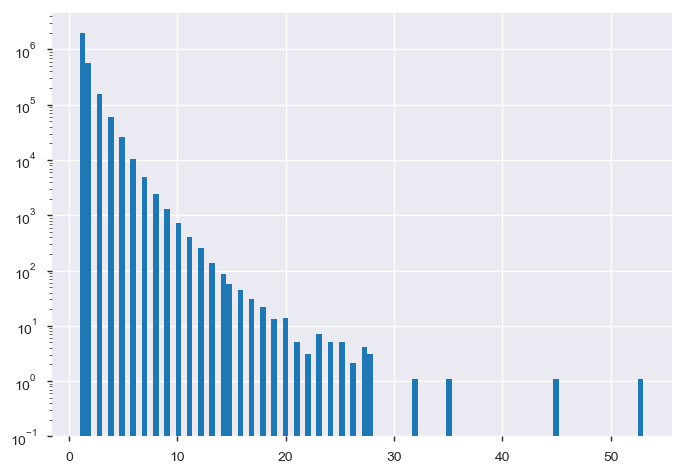

In [42]:
n_w_byVIN = df_proc.W_VIN.value_counts()
fig, ax = plt.subplots()
n_w_byVIN.hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')

- 同一車体でも、複数回入庫する場合がそれなりにある。
    - (スズキ様コメント)1レコードであっても、複数のパーツを交換することが一般的。なので、主原因部品の他にも、交換されたパーツがあるのが通常。
- (スズキ様コメント)ワランティテーブルと生産テーブルはVIN列でつながっている。ワランティは全データをカバーしているが、生産データは一部しかカバーしていない。イメージとしては、四輪のインドネシアはカバーできていない、など。グループを分ければ、全てカバーできうる。

## 時系列プロット

### 全体

In [16]:
display_all(df_fcok_tmp.head())

,V_BASE_CD,V_PROD_DIV,V_VIN,V_ENGINE_NO,V_MOTOR_NO,V_MISSON_NO,V_KEY_NO,V_FCOK,V_FCOK_TIME,V_ABOK,V_ABOK_TIME,V_PROD_MODEL_CD,V_SALES_MODEL_CD,V_SALES_MODEL_NM,V_SPEC,V_COLOR,V_PLANT_CD,V_DIST_CD,V_BRANCH_CD,V_SHIPPING_DATE,V_SHIPPING_FCOK,V_SHIPPING_ABOK,V_INVOICE_NO,V_SALES_NO,V_CASE_NO,V_SRC_DIV,V_CRT_TIME_STAMP
0,100100,B,JSAEAB35S00251388,G13BA379590,NaN,R543705,U0954,19940401,163500.0,19940331.0,142700.0,Y0G14CDC,SF413,NaN,E54,15P,NaN,143500,NaN,19940519.0,NaN,NaN,BEP-8264,BWI-1804,212.0,1,16-12-15 10:50:08.623609000
1,100100,B,JSAEAB35S00251391,G13BA381372,NaN,R543154,U0954,19940401,103000.0,19940330.0,160100.0,Y0G14CCC,SF413,NaN,E24,26U,NaN,601520,NaN,19940422.0,NaN,NaN,BT-13542,BMD-2423,147.0,1,16-12-15 10:50:08.624999000
2,100100,B,JSAEAB35S00251400,G13BA379586,NaN,R543802,U0965,19940401,111300.0,19940401.0,85900.0,Y0G14CCC,SF413,NaN,E24,1FG,NaN,601550,NaN,19940427.0,NaN,NaN,BT-13603,BMD-2426,27.0,1,16-12-15 10:50:08.626269000
3,100100,B,JSAEAB35S00251408,G13BA379562,NaN,R543821,U1336,19940401,94100.0,19940331.0,164200.0,Y0G14CCC,SF413,NaN,E24,26U,NaN,601550,NaN,19940427.0,NaN,NaN,BT-13603,BMD-2426,42.0,1,16-12-15 10:50:08.627560000
4,100100,B,JSAEAB35S00251409,G13BA381312,NaN,R967489,U1307,19940401,93900.0,19940331.0,163500.0,Y0G14CPC,SF413,NaN,E24,26U,NaN,601520,NaN,19940427.0,NaN,NaN,BT-13604,BMD-2427,78.0,1,16-12-15 10:50:08.628907000


In [45]:
n_proc_byM = df_proc.groupby("W_PROCESS_MONTH")["W_VIN"].apply(len).to_frame()
n_proc_byM["N_VIN"] = df_proc.groupby("W_PROCESS_MONTH")["W_VIN"].nunique()
n_proc_byM = n_proc_byM.reset_index()
n_proc_byM["W_PROCESS_MONTH_DT"] = pd.to_datetime(n_proc_byM["W_PROCESS_MONTH"].astype(str) \
                                                  + "01")
n_proc_byM.rename(columns={"W_VIN":"N_W"},inplace=True)

Text(0, 0.5, 'number of warranty and VIN')

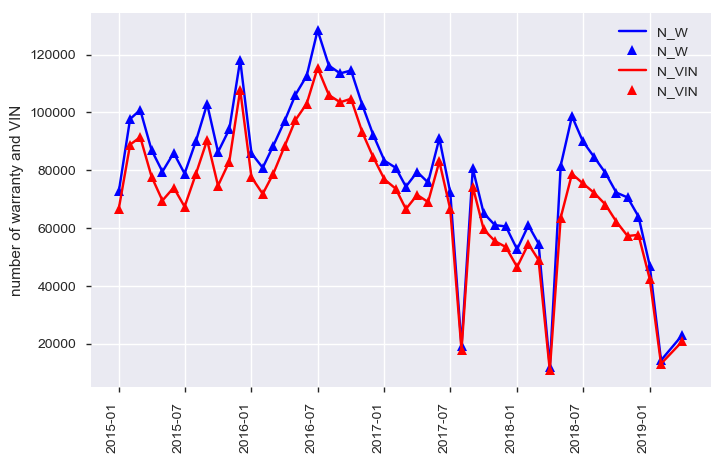

In [46]:
# 件数
fig, ax1 = plt.subplots()
ax1.plot(n_proc_byM.W_PROCESS_MONTH_DT, n_proc_byM.N_W , 'b-')       
ax1.plot(n_proc_byM.W_PROCESS_MONTH_DT, n_proc_byM.N_W,'b^')
ax1.plot(n_proc_byM.W_PROCESS_MONTH_DT, n_proc_byM.N_VIN , 'r-')       
ax1.plot(n_proc_byM.W_PROCESS_MONTH_DT, n_proc_byM.N_VIN,'r^')
plt.legend()
fig.autofmt_xdate(rotation=90)
ax1.set_ylabel("number of warranty and VIN")

In [75]:
n_proc_byM.sort_values(by="N_W").head()

,W_PROCESS_MONTH,W_PROCESS_MONTH_TYPE,N_W,W_PROCESS_MONTH_DT,W_PROCESS_YEAR
39,201804,04,12049,2018-04-01,2018
49,201902,02,14265,2019-02-01,2019
31,201708,08,19199,2017-08-01,2017
50,201904,04,23083,2019-04-01,2019
48,201901,01,47012,2019-01-01,2019


Text(0.5, 1.0, 'autocorrelation of number of warranty per month')

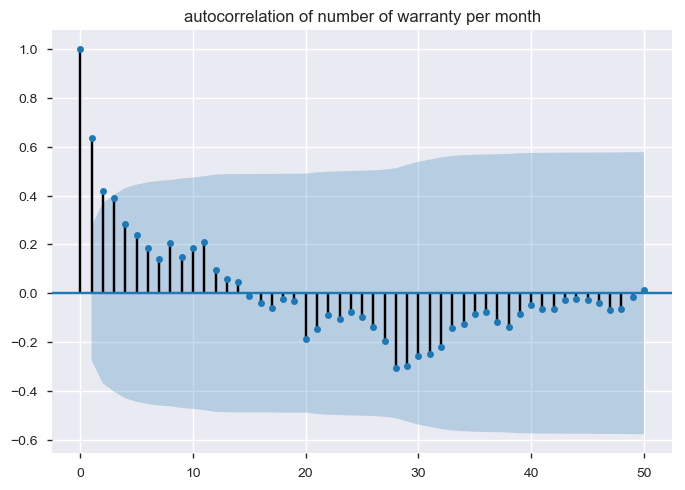

In [50]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(n_proc_byM.N_W)
plt.title("autocorrelation of number of warranty per month")

In [ ]:
# 割合

#### 月毎に比較

In [51]:
df_proc["W_PROCESS_MONTH_TYPE"] = df_proc.W_PROCESS_MONTH.astype(str).str[4:]

n_proc_byM = df_proc.groupby(["W_PROCESS_MONTH","W_PROCESS_MONTH_TYPE"])["W_VIN"].apply(len).to_frame()
n_proc_byM = n_proc_byM.reset_index()
n_proc_byM["W_PROCESS_MONTH_DT"] = pd.to_datetime(n_proc_byM["W_PROCESS_MONTH"].astype(str) + "01")
n_proc_byM.rename(columns={"W_VIN":"N_W"},inplace=True)

n_proc_byM["W_PROCESS_YEAR"] = n_proc_byM["W_PROCESS_MONTH"].astype(str).str[:4]

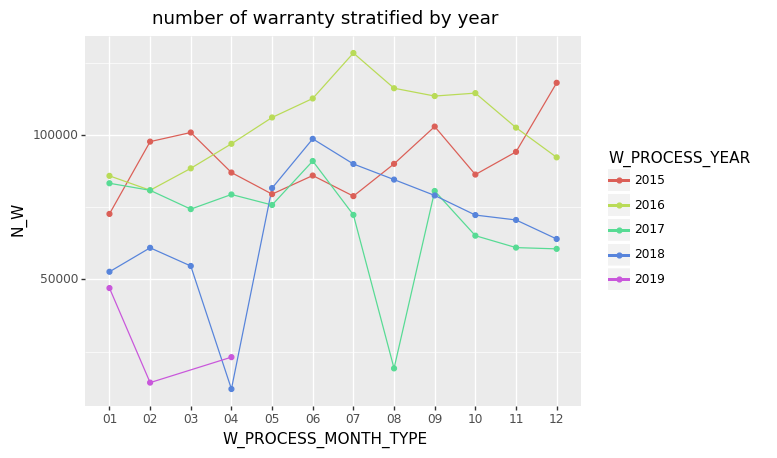

<ggplot: (-9223372029276050102)>

In [52]:
# 件数
g = (ggplot(n_proc_byM.drop("W_PROCESS_MONTH", axis=1), 
            aes(x="W_PROCESS_MONTH_TYPE", y="N_W",color="W_PROCESS_YEAR", group="W_PROCESS_YEAR")) 
     + geom_line()
     + geom_point()
     + ggtitle("number of warranty stratified by year"))
g

**確認:** 2017年8月、2018年4月,2019年2月以降の極端な低下が疑問。

(スズキ様コメント)特定のパーツ、例えば船外機などは、夏が多くなり、冬が少なくなる。パーツ毎で見る必要がある。

In [ ]:
# 割合

### パーツ毎

In [ ]:
# パーツの統計量再び

In [ ]:
# 上記をパーツで層別して行う。量が多い場合、上位30などをプロット。

### 地域毎

In [ ]:
# 地域の統計量再び

In [ ]:
# 上記を地域毎で層別して行う。量が多い場合、上位30などをプロット。

### 車両モデル毎

In [ ]:
# 車両モデルの統計量再び

In [ ]:
# 上記を車両モデルで層別して行う。量が多い場合、上位30などをプロット。

## 故障までの経過期間プロット

### 全体

In [53]:
print(df_proc.W_SALES_TO_FAILURE.max())
print(df_proc.W_SALES_TO_FAILURE.min())

999
-64


外れ値か。

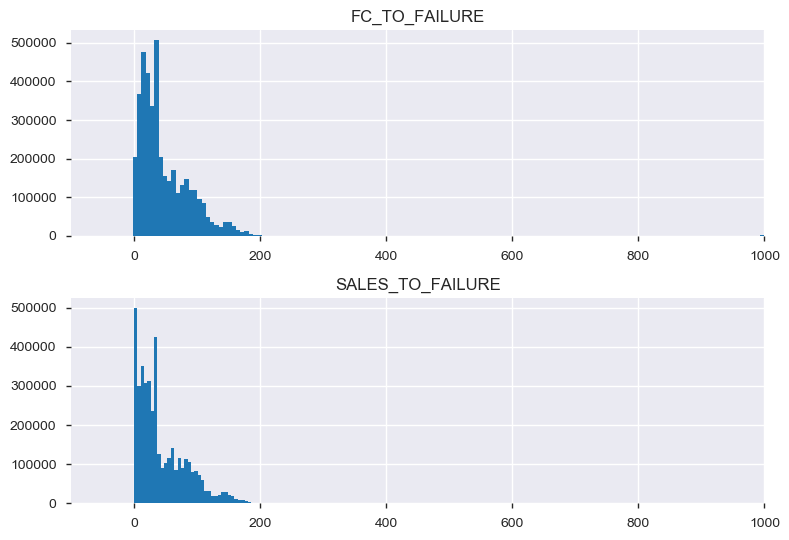

In [55]:
# 件数
plt.subplot(2, 1, 1)
df_proc.W_FC_TO_FAILURE.hist(bins=200)
plt.title("FC_TO_FAILURE")
plt.xlim(-100, 1000)
plt.subplot(2, 1, 2)
df_proc.W_SALES_TO_FAILURE.hist(bins=200)
plt.xlim(-100, 1000)
plt.title("SALES_TO_FAILURE")
plt.tight_layout()

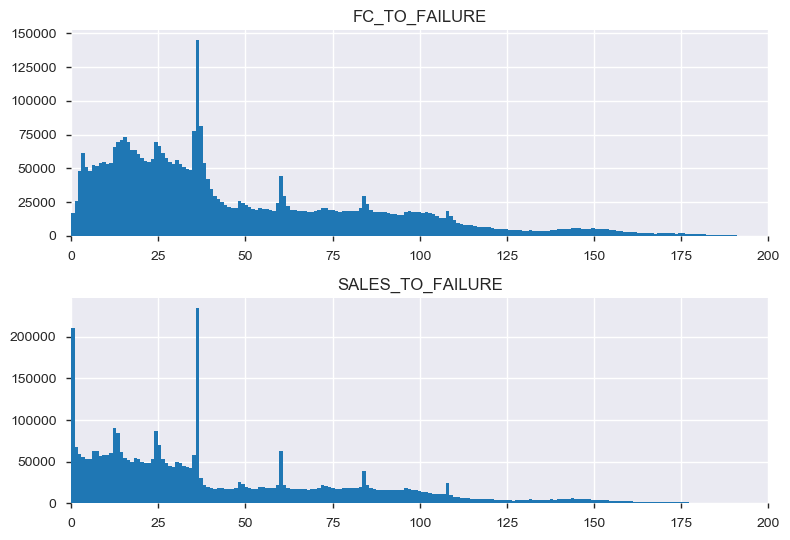

In [66]:
# 件数
plt.subplot(2, 1, 1)
df_proc.W_FC_TO_FAILURE[np.logical_and(df_proc.W_FC_TO_FAILURE<200,df_proc.W_FC_TO_FAILURE>=0)].hist(bins=200)
plt.title("FC_TO_FAILURE")
plt.xlim(0, 200)
plt.subplot(2, 1, 2)
df_proc.W_SALES_TO_FAILURE[np.logical_and(df_proc.W_SALES_TO_FAILURE<200,df_proc.W_SALES_TO_FAILURE>=0)].hist(bins=200)
plt.xlim(0, 200)
plt.title("SALES_TO_FAILURE")
plt.tight_layout()

(0, 200)

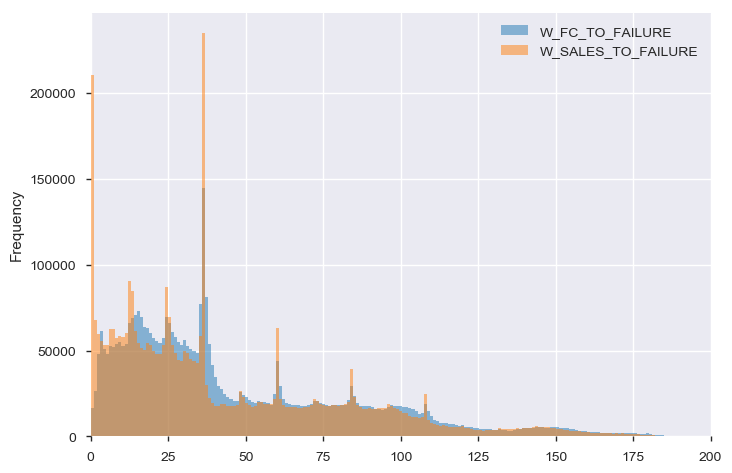

In [71]:
T_TO_FAILURE_COLS = ["W_FC_TO_FAILURE","W_SALES_TO_FAILURE"]

df_proc.loc[np.logical_and.reduce([df_proc.W_FC_TO_FAILURE<200, df_proc.W_FC_TO_FAILURE>=0,
                                  df_proc.W_SALES_TO_FAILURE<200, df_proc.W_SALES_TO_FAILURE>=0]),
           T_TO_FAILURE_COLS]\
    .plot.hist(bins=200, alpha=0.5)
plt.xlim(0,200)

- 販売日からの経過月数に比べて、生産日からの経過月数はピークが緩やか
    - 当然だが、生産から販売まで期間があるので、W_FC_TO_FAILUREはW_SALES_TO_FAILUREを少し右に均したようなグラフとなっている
    - 使用するであれば、W_SALES_TO_FAILUREを使うべき。
- 36(3年), 0(直後), 60(5年後), 24(2年後), 12(1年後), 84(7年後)にピークがある
    - 48(4年), 72(6年), 108(9年後)にも小さくピークがある
    - 96(8年後)はピークは見えない
    - 156(13年)を超えるとほぼなくなる。

- (スズキ様コメント)原則として保証は3年まで。37ヶ月以降は保証がないが、無理やり修理したデータなど。
- (スズキ様コメント)12ヶ月毎に点検があるため、12ヶ月にピークが発生する

- この時点で、恐らくはワイブル分布等のパラメトリックな生存分析は適用しにくいことがわかる。
- 混合分布を考えるか、もしくはCox比例ハザード等のセミパラメトリックなモデルを適用する必要がある。

In [72]:
display_all(df_proc.W_SALES_TO_FAILURE
            .value_counts().sort_index()
            .to_frame().T)

,-64,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,264,265,266,267,268,270,271,275,277,278,279,280,284,285,288,290,292,309,311,312,313,314,315,318,323,340,999
W_SALES_TO_FAILURE,1,210795,67804,59504,55652,53311,53139,62856,62627,57306,58399,58100,60366,90859,84843,61490,54739,51551,50118,54434,53280,50019,47927,47984,53535,87096,69726,53563,48427,44462,43905,49732,48772,45072,43728,42967,58529,235081,30192,22627,19329,18025,17607,18755,18639,17752,17577,17457,18120,26291,22922,19526,18141,17266,17817,20307,20176,18865,18717,19093,21701,62937,22070,18233,17293,17117,17022,17309,16787,16529,17168,17413,18371,21795,20909,19139,18400,17709,17650,18522,18112,17983,18296,18704,19813,39235,22692,18485,16891,16087,15817,16684,15974,15786,16371,16511,16598,18741,17612,16568,15941,14708,13701,13412,12183,11546,11413,10930,11099,24556,9708,8013,7311,6797,6351,6445,5900,5771,5715,5492,5272,5864,4868,4619,4206,3832,3814,3830,3435,3557,3652,3707,3892,5090,4242,4115,4296,4155,4579,4836,4434,4823,5003,5138,5366,6226,5560,5765,5441,5220,4841,4683,4246,4101,3783,3503,3435,3415,3088,2918,2551,2558,2418,2148,2045,1783,1744,1724,1723,1792,1698,1706,1513,1717,1659,1509,1320,1230,1166,1090,916,876,691,554,472,460,400,385,341,289,274,244,302,286,245,199,180,153,130,118,118,109,101,98,73,84,81,64,79,65,52,54,62,22,38,34,35,31,29,24,29,29,14,18,15,22,12,18,15,14,26,13,11,10,9,11,7,11,8,6,13,8,6,8,5,4,6,6,7,2,5,3,2,3,3,3,2,2,4,3,1,2,2,1,3,5,1,2,1,1,1,1,2,1,2,2,1,1,1,1,1,1,2,1,1,1,1,1,1,2,33


**確認** -64と999

### パーツ毎

In [ ]:
# パーツの統計量再び

In [ ]:
# 上記をパーツで層別して行う。量が多い場合、上位30などをプロット。関数化しておく。

### 地域毎

In [ ]:
# 地域の統計量再び

In [ ]:
# 上記を地域で層別して行う。量が多い場合、上位30などをプロット。

### 車両モデル毎

In [ ]:
# 車両モデルの統計量再び。

In [ ]:
# 上記を車両モデルで層別して行う。量が多い場合、上位30などをプロット。